In [1]:
"""
    Dataset (Bangla Online Comments Dataset) : https://data.mendeley.com/datasets/9xjx8twk8p/1
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
# Loading Bangla Online Comments Dataset
bully = []
not_bully = []


df = pd.read_excel('../datasets/bangla_online_comments_dataset.xlsx')

labels = np.array(df['label'].tolist())
print(np.unique(labels, return_counts=True))

for index, row in df.iterrows():
    if row['label'] == 'not bully':
        not_bully.append(row['comment'])
    elif row['label'] != 'sexual':
        bully.append(row['comment'])
    
print(len(bully), 'bully')
print(len(not_bully), 'not_bully')

import random
random.shuffle(bully)

for i in range(len(bully)-len(not_bully)):
    bully.pop(0)

print("After Balancing")
print(len(bully), 'bully')
print(len(not_bully), 'not_bully')


y_pos = [1 for i in range(len(not_bully))]
y_neg = [0 for i in range(len(bully))]

X = not_bully + bully
y = y_pos + y_neg

(array(['not bully', 'religious', 'sexual', 'threat', 'troll'], dtype='<U9'), array([15340,  7577,  8928,  1694, 10462], dtype=int64))
19733 bully
15340 not_bully
After Balancing
15340 bully
15340 not_bully


In [3]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

229077


In [4]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

y_train_val_e = to_categorical(y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val_e, test_size=0.2, random_state=1, stratify=y_train_val_e)



In [5]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [6]:
def nlp_cnn(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding_layer = embedding_layer(inputs)

    conv = Conv1D(600, 3, padding='same', activation='relu')(embedding_layer)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)

    conv = Conv1D(800, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)
    
    conv = Conv1D(1000, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPool1D(pool_size=(2))(conv)

    conv = Conv1D(1200, 3, padding='same', activation='relu')(conv)
    conv = BatchNormalization()(conv)
    
    output = GlobalAveragePooling1D()(conv)

    output = Dense(units=1200, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=600, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=300, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(units=100, activation='relu')(output)
    output = Dense(units=2, activation='sigmoid')(output)
    
    model = Model(inputs, output)
    return model


model = nlp_cnn(w2v_model)



checkpoint = ModelCheckpoint('./model2.h5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          68723100  
                                                                 
 conv1d (Conv1D)             (None, 200, 600)          540600    
                                                                 
 batch_normalization (BatchN  (None, 200, 600)         2400      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 600)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 800)          144080

Epoch 16/30
613/614 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9811
Epoch 16: val_accuracy did not improve from 0.70707
614/614 [==============================] - 41s 67ms/step - loss: 0.0517 - accuracy: 0.9812 - val_loss: 7.7200 - val_accuracy: 0.5402
Epoch 17/30
613/614 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9820
Epoch 17: val_accuracy did not improve from 0.70707
614/614 [==============================] - 40s 66ms/step - loss: 0.0510 - accuracy: 0.9820 - val_loss: 16.8395 - val_accuracy: 0.5009
Epoch 18/30
613/614 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9807
Epoch 18: val_accuracy improved from 0.70707 to 0.75535, saving model to .\model2.h5
614/614 [==============================] - 41s 67ms/step - loss: 0.0491 - accuracy: 0.9807 - val_loss: 1.6107 - val_accuracy: 0.7553
Epoch 19/30
613/614 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9825
Epoch 19: val_accuracy 

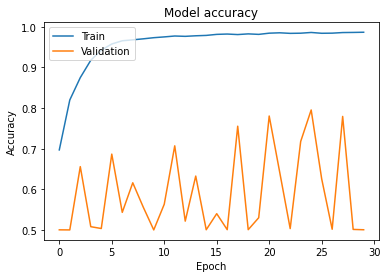

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
# Taking the last layer predictions
model = load_model('./model2.h5')
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

192/192 [==============================] - 3s 16ms/step


In [9]:
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF CNN")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF CNN
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      3068
           1       0.77      0.85      0.81      3068

    accuracy                           0.80      6136
   macro avg       0.80      0.80      0.80      6136
weighted avg       0.80      0.80      0.80      6136

0.796284224250326


In [10]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)
f = Model(model.input, model.layers[13].output)
fe_train_val = f.predict(X_train_val)
fe_test = f.predict(X_test)


def flatten_features(x):
    x_flatten = []
    for f in x:
        f = f.flatten()
        x_flatten.append(f)
    x_flatten = np.array(x_flatten)
    return x_flatten


input_1 0
embedding 1
conv1d 2
batch_normalization 3
max_pooling1d 4
conv1d_1 5
batch_normalization_1 6
max_pooling1d_1 7
conv1d_2 8
batch_normalization_2 9
max_pooling1d_2 10
conv1d_3 11
batch_normalization_3 12
global_average_pooling1d 13
dense 14
dropout 15
dense_1 16
dropout_1 17
dense_2 18
dropout_2 19
dense_3 20
dense_4 21
192/192 [==============================] - 3s 13ms/step


In [11]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

f_train_val = flatten_features(fe_train_val)
f_test = flatten_features(fe_test)

# f_train_val = scaler.fit_transform(fe_train_val)
# f_test = scaler.fit_transform(fe_test)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True,verbose=10)

# Taking only 20% of data due to hardware issues
gx, f, gy, ff = train_test_split(f_train_val, y_train_val, test_size=0.8, random_state=1, stratify=y_train_val)

grid_search=grid.fit(gx, gy)
print(grid_search.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5; 1/49] START n_neighbors=1..............................................
[CV 1/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.919) total time=   0.1s
[CV 2/5; 1/49] START n_neighbors=1..............................................
[CV 2/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.938) total time=   0.0s
[CV 3/5; 1/49] START n_neighbors=1..............................................
[CV 3/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.916) total time=   0.0s
[CV 4/5; 1/49] START n_neighbors=1..............................................
[CV 4/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.925) total time=   0.1s
[CV 5/5; 1/49] START n_neighbors=1..............................................
[CV 5/5; 1/49] END n_neighbors=1;, score=(train=1.000, test=0.926) total time=   0.0s
[CV 1/5; 2/49] START n_neighbors=2..............................................
[CV 1/5; 2/49] END n_n

[CV 5/5; 10/49] END n_neighbors=10;, score=(train=0.957, test=0.954) total time=   0.1s
[CV 1/5; 11/49] START n_neighbors=11............................................
[CV 1/5; 11/49] END n_neighbors=11;, score=(train=0.955, test=0.947) total time=   0.1s
[CV 2/5; 11/49] START n_neighbors=11............................................
[CV 2/5; 11/49] END n_neighbors=11;, score=(train=0.955, test=0.954) total time=   0.1s
[CV 3/5; 11/49] START n_neighbors=11............................................
[CV 3/5; 11/49] END n_neighbors=11;, score=(train=0.954, test=0.951) total time=   0.1s
[CV 4/5; 11/49] START n_neighbors=11............................................
[CV 4/5; 11/49] END n_neighbors=11;, score=(train=0.955, test=0.950) total time=   0.1s
[CV 5/5; 11/49] START n_neighbors=11............................................
[CV 5/5; 11/49] END n_neighbors=11;, score=(train=0.956, test=0.953) total time=   0.1s
[CV 1/5; 12/49] START n_neighbors=12...............................

[CV 4/5; 20/49] END n_neighbors=20;, score=(train=0.953, test=0.952) total time=   0.1s
[CV 5/5; 20/49] START n_neighbors=20............................................
[CV 5/5; 20/49] END n_neighbors=20;, score=(train=0.953, test=0.951) total time=   0.1s
[CV 1/5; 21/49] START n_neighbors=21............................................
[CV 1/5; 21/49] END n_neighbors=21;, score=(train=0.955, test=0.950) total time=   0.1s
[CV 2/5; 21/49] START n_neighbors=21............................................
[CV 2/5; 21/49] END n_neighbors=21;, score=(train=0.952, test=0.958) total time=   0.1s
[CV 3/5; 21/49] START n_neighbors=21............................................
[CV 3/5; 21/49] END n_neighbors=21;, score=(train=0.955, test=0.951) total time=   0.1s
[CV 4/5; 21/49] START n_neighbors=21............................................
[CV 4/5; 21/49] END n_neighbors=21;, score=(train=0.955, test=0.952) total time=   0.1s
[CV 5/5; 21/49] START n_neighbors=21...............................

[CV 3/5; 30/49] END n_neighbors=30;, score=(train=0.953, test=0.950) total time=   0.1s
[CV 4/5; 30/49] START n_neighbors=30............................................
[CV 4/5; 30/49] END n_neighbors=30;, score=(train=0.955, test=0.950) total time=   0.1s
[CV 5/5; 30/49] START n_neighbors=30............................................
[CV 5/5; 30/49] END n_neighbors=30;, score=(train=0.952, test=0.951) total time=   0.1s
[CV 1/5; 31/49] START n_neighbors=31............................................
[CV 1/5; 31/49] END n_neighbors=31;, score=(train=0.955, test=0.950) total time=   0.1s
[CV 2/5; 31/49] START n_neighbors=31............................................
[CV 2/5; 31/49] END n_neighbors=31;, score=(train=0.951, test=0.958) total time=   0.1s
[CV 3/5; 31/49] START n_neighbors=31............................................
[CV 3/5; 31/49] END n_neighbors=31;, score=(train=0.954, test=0.949) total time=   0.1s
[CV 4/5; 31/49] START n_neighbors=31...............................

[CV 2/5; 40/49] END n_neighbors=40;, score=(train=0.951, test=0.958) total time=   0.1s
[CV 3/5; 40/49] START n_neighbors=40............................................
[CV 3/5; 40/49] END n_neighbors=40;, score=(train=0.954, test=0.948) total time=   0.1s
[CV 4/5; 40/49] START n_neighbors=40............................................
[CV 4/5; 40/49] END n_neighbors=40;, score=(train=0.954, test=0.950) total time=   0.1s
[CV 5/5; 40/49] START n_neighbors=40............................................
[CV 5/5; 40/49] END n_neighbors=40;, score=(train=0.953, test=0.952) total time=   0.1s
[CV 1/5; 41/49] START n_neighbors=41............................................
[CV 1/5; 41/49] END n_neighbors=41;, score=(train=0.953, test=0.951) total time=   0.1s
[CV 2/5; 41/49] START n_neighbors=41............................................
[CV 2/5; 41/49] END n_neighbors=41;, score=(train=0.951, test=0.958) total time=   0.1s
[CV 3/5; 41/49] START n_neighbors=41...............................

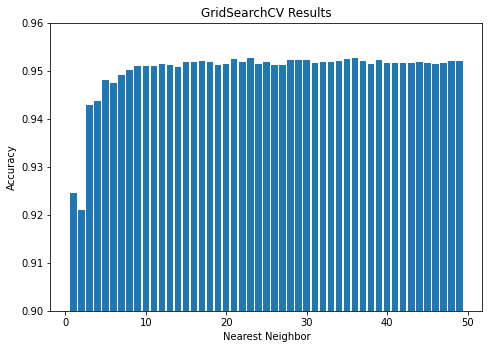

In [13]:
neighbors = []
l = []
for i, p in enumerate(grid.cv_results_['mean_test_score']):
    neighbors.append({'neighbor': i+1, 'score': p})
    l.append(i+1)

neighbors.sort(key=lambda x: x['score'], reverse=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(l,grid.cv_results_['mean_test_score'])
ax.set_ylim([0.9, 0.96])
plt.title('GridSearchCV Results')
plt.ylabel('Accuracy')
plt.xlabel('Nearest Neighbor')
plt.show()

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=neighbors[0]['neighbor'])
knn.fit(f_train_val, y_train_val)
preds = knn.predict(f_test)
preds_proba = knn.predict_proba(f_test)
print(classification_report(y_test, preds))
print("KNN", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3068
           1       0.82      0.83      0.83      3068

    accuracy                           0.83      6136
   macro avg       0.83      0.83      0.83      6136
weighted avg       0.83      0.83      0.83      6136

KNN 0.8251303780964798


In [15]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier
knn1 = KNeighborsClassifier(n_neighbors=neighbors[0]['neighbor'])

knn2 = KNeighborsClassifier(n_neighbors=neighbors[1]['neighbor'])

knn3 = KNeighborsClassifier(n_neighbors=neighbors[2]['neighbor'])

knn4 = KNeighborsClassifier(n_neighbors=neighbors[3]['neighbor'])

knn5 = KNeighborsClassifier(n_neighbors=neighbors[4]['neighbor'])

eclf1 = VotingClassifier(estimators=[('knn1', knn1),
                                     ('knn2', knn2),
                                    ('knn3', knn3),
                                     ('knn4', knn4),
                                     ('knn5', knn5),
                                    ], voting='soft')

eclf1.fit(f_train_val, y_train_val)

preds = eclf1.predict(f_test)

In [16]:
print(classification_report(y_test, preds))
print("KNN VOTING", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3068
           1       0.82      0.83      0.83      3068

    accuracy                           0.83      6136
   macro avg       0.83      0.83      0.83      6136
weighted avg       0.83      0.83      0.83      6136

KNN VOTING 0.825619295958279


In [17]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=3)
svclassifier.fit(f_train_val, y_train_val)
preds = svclassifier.predict(f_test)
print(classification_report(y_test, preds))
print("SVM ", accuracy_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3068
           1       0.82      0.84      0.83      3068

    accuracy                           0.83      6136
   macro avg       0.83      0.83      0.83      6136
weighted avg       0.83      0.83      0.83      6136

SVM  0.8251303780964798
